# 1. Install and import libraries

In [1]:
!pip install numba==0.61.0 torchaudio==2.6.0 librosa==0.10.2.post1 timm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import timm

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Download audio dataset

In [3]:
!gdown 1u2WzsWUlyZbbPDfXAWXuLRMTwFkT21wa
!unzip -q crawled_piano_audio_40_pages.zip -d piano_audio_files_40_pages
os.remove("crawled_piano_audio_40_pages.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1u2WzsWUlyZbbPDfXAWXuLRMTwFkT21wa
From (redirected): https://drive.google.com/uc?id=1u2WzsWUlyZbbPDfXAWXuLRMTwFkT21wa&confirm=t&uuid=8f3380c4-dc6a-4c79-a1f2-4bf5eff73705
To: /kaggle/working/crawled_piano_audio_40_pages.zip
100%|██████████████████████████████████████| 4.35G/4.35G [00:58<00:00, 74.0MB/s]


# 3. Define audio data processing functions

In [4]:
def load_and_get_genres(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    return data.get('genres', [])

json_dir = os.path.join("piano_audio_files", "crawled_data")

In [5]:
def load_and_resample_audio(file_path, target_sr=22050):
    audio, sr = librosa.load(file_path, sr=None)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

    return audio, target_sr

def audio_to_melspec(audio, sr, n_mels, n_fft=2048, hop_length=512, to_db=False):
    spec = librosa.feature.melspectrogram(y=audio,
                                          sr=sr,
                                          n_mels=n_mels,
                                          n_fft=n_fft,
                                          hop_length=hop_length,
                                          win_length=None,
                                          window='hann',
                                          center=True,
                                          pad_mode='reflect',
                                          power=2.0)
    if to_db:
        spec = librosa.power_to_db(spec, ref=np.max)
    return spec

def normalize_melspec(melspec, norm_range=(0, 1)):
    scaler = MinMaxScaler(feature_range=norm_range)
    melspec = melspec.T
    melspec_normalized = scaler.fit_transform(melspec)
    return melspec_normalized.T

def denormalize_melspec(melspec_normalized, original_melspec, norm_range=(0, 1)):
    scaler = MinMaxScaler(feature_range=norm_range)
    melspec = original_melspec.T
    scaler.fit(melspec)
    melspec_denormalized = scaler.inverse_transform(melspec_normalized.T)
    return melspec_denormalized.T


def melspec_to_audio(melspec, sr, n_fft=2048, hop_length=512, n_iter=64):
    if np.any(melspec < 0):
        melspec = librosa.db_to_power(melspec)

    audio_reconstructed = librosa.feature.inverse.mel_to_audio(M=melspec,
                                          sr=sr,
                                          n_fft=n_fft,
                                          hop_length=hop_length,
                                          win_length=None,
                                          window='hann',
                                          center=True,
                                          pad_mode='reflect',
                                          power=2.0,
                                          n_iter=n_iter)

    return audio_reconstructed

def display_audio_files(reconstructed_audio, sr, title="", original_audio=None):
    if original_audio is not None:
        print("Original Audio:")
        ipd.display(ipd.Audio(original_audio, rate=sr))
        print("Reconstructed Audio (from Mel Spectrogram):")
    else:
        print(title)

    ipd.display(ipd.Audio(reconstructed_audio, rate=sr))

def show_spectrogram(spectrogram, title="Mel-Spectrogram", denormalize=False, is_numpy=False):
    if not is_numpy:
        spectrogram = spectrogram.squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    if denormalize:
        plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="viridis")
    else:
        plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="viridis", vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.colorbar()
    plt.show()

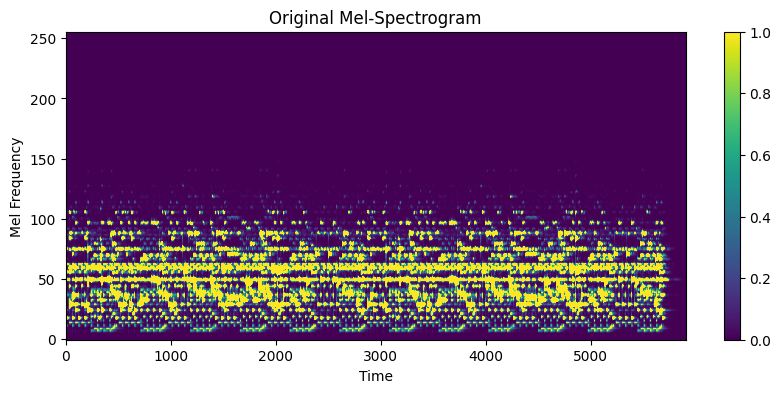

In [6]:
audio, target_sr = load_and_resample_audio(os.path.join("piano_audio_files_40_pages", "crawled_data", "audio", "audio_0001.mp3"))

mel_spectrogram = audio_to_melspec(audio, target_sr, n_mels=256)

show_spectrogram(mel_spectrogram, title="Original Mel-Spectrogram", is_numpy=True)

In [7]:
json_dir = os.path.join("piano_audio_files_40_pages", "crawled_data")
all_genres = []

for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(json_dir, filename)
        genres = load_and_get_genres(json_path)
        all_genres.extend(genres)

unique_genres = set(all_genres)
max_genres = len(unique_genres)
print(f"Total unique genres: {max_genres}")
print(f"Unique genres: {unique_genres}")

Total unique genres: 95
Unique genres: {'Improv', 'Celtic', 'New Age', 'Rap', 'Gospel', 'Progressive', 'Historic', 'Comedy', 'Lo-fi Rock', 'Downtempo', 'New Wave', 'Lo-fi Electronic', 'Radio', 'Halloween', 'Pop', 'Unclassifiable', 'Rock', 'Afrobeat', 'Jazz: Out', 'Space-Rock', 'Mbaqanga', 'Trip-Hop', 'Instrumental', 'Acoustic', 'Funk', 'International', 'Chill-out', 'Electroacoustic', 'Lo-fi Instrumental', 'Radio Art', 'Dance', 'Experimental', 'Ambient', 'Talk Radio', 'hiphop', 'Tango', 'Drum & Bass', 'Sound Poetry', 'Blues', 'Lo-fi Experimental', 'Lo-fi Soul-RnB', 'Indie-Rock', 'Goth', 'Piano', 'Ambient Electronic', 'Big Band/Swing', 'Soul-RnB', 'Techno', 'Hip-Hop Beats', 'Wonky', 'Novelty', 'Jazz', 'Hip-Hop', 'Country & Western', 'Europe', 'Symphony', 'Jungle', 'Americana', 'Sound Effects', 'Soundtrack', '20th Century Classical', 'Composed Music', 'Vaporwave', 'Folk', 'Experimental Pop', 'House', 'British Folk', 'Contemporary Classical', 'Post-Rock', 'Drone', 'Kid-Friendly', 'Metal', 

In [8]:
genres2idx = {genre: idx for idx, genre in enumerate(unique_genres)}
idx2genres = {idx: genre for genre, idx in genres2idx.items()}

def tokenize(genres):
    return [genres2idx[genre] for genre in genres if genre in genres2idx]

def detokenize_tolist(tokens):
    return [idx2genres[token] for token in tokens if token in idx2genres]

def onehot_encode(tokens, max_genres):
    onehot = torch.zeros(max_genres)
    onehot[tokens] = 1
    return onehot

def onehot_decode(onehot):
    return [idx for idx, val in enumerate(onehot) if val == 1]

# 4. Create PyTorch DataLoader

In [9]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, json_dir, sample_rate, duration, n_mels, n_genres, testset_amount=10):
        self.data_dir = data_dir
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".mp3")]
        self.json_dir = json_dir
        self.json_files = [os.path.join(json_dir, f) for f in os.listdir(json_dir) if f.endswith(".json")]
        self.sample_rate = sample_rate
        self.duration = duration
        self.fixed_length = sample_rate * duration
        self.n_genres = n_genres
        self.n_mels = n_mels

        audios = []
        for file_path, json_file_path in tqdm(zip(self.files, self.json_files), desc=f"Loading audio files in {data_dir}", unit="file", total=len(self.files)):
            audio, sr = load_and_resample_audio(file_path, target_sr=sample_rate)
            genres_list = load_and_get_genres(json_file_path)

            genres_tokens = tokenize(genres_list)
            genres_input = onehot_encode(genres_tokens, n_genres)
            genres_input = torch.tensor(genres_input, dtype=torch.long).unsqueeze(0)

            n_samples = len(audio)
            n_segments = n_samples // self.fixed_length

            for i in range(n_segments):
                start = i * self.fixed_length
                end = (i + 1) * self.fixed_length
                segment = audio[start:end]
                mel_spec = audio_to_melspec(segment, sr, self.n_mels, to_db=True)
                mel_spec_norm = normalize_melspec(mel_spec)
                mel_spec = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)
                mel_spec_norm = torch.tensor(mel_spec_norm, dtype=torch.float32).unsqueeze(0)
                audios.append((mel_spec_norm, genres_input, mel_spec))

        self.audios = audios[:len(audios) - testset_amount]
        self.testset = audios[len(audios) - testset_amount:]
        print(f"Loaded {len(self.audios)} audio segments from {len(self.files)} files, each with shape: {self.audios[0][0].shape}, {self.audios[0][1].shape}, duration: {duration} seconds")
        print(f"Test set: {len(self.testset)} audio segments")

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        mel_spec_part, genres_input, mel_spec = self.audios[idx]

        return mel_spec_part, genres_input, mel_spec

In [10]:
sample_rate = 22050
duration = 3
n_mels = 256

audio_dir = os.path.join("piano_audio_files_40_pages", "crawled_data", "audio")
json_dir = os.path.join("piano_audio_files_40_pages", "crawled_data")

testset_amount = 32
trainset = AudioDataset(audio_dir, json_dir, sample_rate, duration,
                        n_mels, max_genres, testset_amount=testset_amount)
testset = trainset.testset

if len(trainset) == 0:
    raise ValueError(f"No .wav file found in {audio_dir}.")

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=testset_amount, shuffle=False, num_workers=4)

Loading audio files in piano_audio_files_40_pages/crawled_data/audio:   0%|          | 0/793 [00:00<?, ?file/s]<ipython-input-9-f7ac63e2d62d>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genres_input = torch.tensor(genres_input, dtype=torch.long).unsqueeze(0)
Loading audio files in piano_audio_files_40_pages/crawled_data/audio:   0%|          | 1/793 [00:00<11:11,  1.18file/s]<ipython-input-9-f7ac63e2d62d>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genres_input = torch.tensor(genres_input, dtype=torch.long).unsqueeze(0)
Loading audio files in piano_audio_files_40_pages/crawled_data/audio:   0%|          | 2/793 [00:02<13:34,  1.03s/file]<ipython-input-9-f7ac63e2d62d>:20: User

Loaded 46035 audio segments from 793 files, each with shape: torch.Size([1, 256, 130]), torch.Size([1, 95]), duration: 3 seconds
Test set: 32 audio segments


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
130


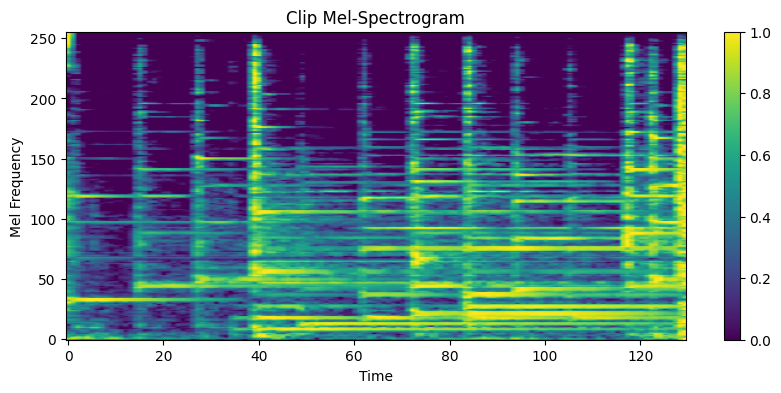

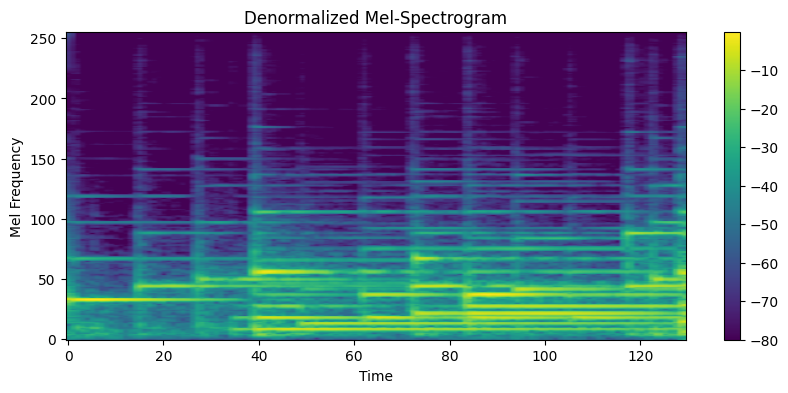

Original Audio after convert to Spectrogram and back to Audio


In [11]:
audios = trainloader.dataset.audios.copy()

frame = audios[0][0].shape[-1]
print(audios[0][1])
print(frame)

for i in range(1):
    show_spectrogram(audios[i][0], title="Clip Mel-Spectrogram")
    spec_denorm = denormalize_melspec(audios[i][0].numpy().squeeze(), audios[i][2].numpy().squeeze())
    show_spectrogram(torch.tensor(spec_denorm), title="Denormalized Mel-Spectrogram", denormalize=True)
    audio_reconstructed = melspec_to_audio(spec_denorm, sample_rate)
    display_audio_files(audio_reconstructed, sample_rate, title="Original Audio after convert to Spectrogram and back to Audio")

# 5. Create VAE model

In [12]:
class CVAE(nn.Module):
    def __init__(self, d_model, latent_dim, n_frames, n_mels, n_genres):
        super(CVAE, self).__init__()
        self.d_model = d_model
        self.latent_dim = latent_dim
        self.n_frames = int(np.ceil(n_frames / 2**3))
        self.n_mels = int(np.ceil(n_mels / 2**3))
        self.n_genres = n_genres

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + self.n_genres, d_model, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(d_model),
            nn.SiLU(),
            nn.Dropout2d(0.05),

            nn.Conv2d(d_model, d_model * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(d_model * 2),
            nn.SiLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(d_model * 2, d_model * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(d_model * 4),
            nn.SiLU(),
            nn.Dropout2d(0.15),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # Latent space
        self.fc_mu = nn.Linear(d_model * 4, latent_dim)
        self.fc_logvar = nn.Linear(d_model * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + self.n_genres, d_model * 4 * self.n_frames * self.n_mels)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(d_model * 4, d_model * 2, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),
            nn.BatchNorm2d(d_model * 2),
            nn.SiLU(),
            nn.Dropout2d(0.1),

            nn.ConvTranspose2d(d_model * 2, d_model, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),
            nn.BatchNorm2d(d_model),
            nn.SiLU(),
            nn.Dropout2d(0.05),

            nn.ConvTranspose2d(d_model, 1, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, genres_input):
        ori_genres_embed = genres_input.view(genres_input.size(0), -1)
        genres_embed = ori_genres_embed.unsqueeze(-1).unsqueeze(-1)
        genres_embed = genres_embed.expand(-1, -1, x.size(2), x.size(3))
        x_genres = torch.cat((x, genres_embed), dim=1)

        h = x_genres
        shortcuts = []
        for block in self.encoder:
            h = block(h)
            if isinstance(block, nn.SiLU):
                shortcuts.append(h)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        z = self.reparameterize(mu, logvar)
        z_genres = torch.cat((z, ori_genres_embed), dim=1)

        h_dec = self.decoder_input(z_genres)
        h_dec = h_dec.view(-1, self.d_model * 4, self.n_frames, self.n_mels)

        for block in self.decoder:
            if isinstance(block, nn.convTranspose2d) and shortcuts:
                shortcut = shortcuts.pop()
                h_dec = h_dec + shortcut
            h_dec = block(h_dec)
        recon = h_dec[:, :, :x.size(2), :x.size(3)]
        return recon, mu, logvar

# 6. Training

In [13]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

In [14]:
def train_vae(model, dataloader, optimizer, scheduler, num_epochs, verbose_interval=50):
    model.train()
    losses = []
    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        train_loss = 0
        for batch_idx, (data, genres_input, ori_data) in enumerate(dataloader):
            data = data.to(device)
            genres_input = genres_input.to(device)

            optimizer.zero_grad()

            recon, mu, logvar = model(data, genres_input)
            loss = loss_function(recon, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        scheduler.step()
        avg_loss = train_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}, Lr: {scheduler.get_last_lr()[0]}")
        if epoch == 0 or (epoch + 1) % verbose_interval == 0:
            data = data[0].detach().cpu()
            recon_img = recon[0].detach().cpu()
            show_spectrogram(data, title="Original Spectrogram")
            show_spectrogram(recon_img, title="Reconstructed Spectrogram")
    return mu, logvar, losses

In [15]:
d_model = 64
latent_dim = 128
lr = 2e-4
num_epochs = 100
step_size = num_epochs//2
verbose_interval = num_epochs//10
gamma = 0.5

model = CVAE(d_model, latent_dim, n_mels, frame, max_genres).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")
mu, logvar, losses = train_vae(model, trainloader, optimizer, scheduler, num_epochs, verbose_interval=verbose_interval)

Total number of parameters: 32056001


Training:   0%|          | 0/100 [00:02<?, ?epoch/s]


AttributeError: module 'torch.nn' has no attribute 'convTranspose2d'

In [ ]:
torch.save(model.state_dict(), "model_checkpoint123.pth")

model = CVAE(d_model, latent_dim, n_mels, frame, max_genres).to(device)
model.load_state_dict(torch.load("model_checkpoint123.pth"))
model.eval()

In [ ]:
def plot_losses(losses, title="Training Loss", xlabel="Epochs", ylabel="Loss", color='b', grid=True):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, color=color, linewidth=2)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(grid, linestyle="--", alpha=0.6)

    min_loss_idx = losses.index(min(losses))
    max_loss_idx = losses.index(max(losses))

    plt.annotate(f"Min Loss: {min(losses):.4f}",
                 xy=(min_loss_idx, min(losses)),
                 xytext=(min_loss_idx + 1, min(losses) + 0.1),
                 arrowprops=dict(arrowstyle="->", color="green"),
                 fontsize=12, color='green')

    plt.annotate(f"Max Loss: {max(losses):.4f}",
                 xy=(max_loss_idx, max(losses)),
                 xytext=(max_loss_idx + 1, max(losses) + 0.1),
                 arrowprops=dict(arrowstyle="->", color="red"),
                 fontsize=12, color="red")

    plt.tight_layout()
    plt.show()

plot_losses(losses)


# 7. Inference

In [ ]:
def inference(model, testloader):
    model.eval()
    with torch.no_grad():
        data, genres_input, ori_data = next(iter(testloader))
        data = data.to(device)
        genres_input = genres_input.to(device)
        recon, _, _ = model(data, genres_input)
        return recon, genres_input, ori_data

In [ ]:
gen_mels, genres_input, ori_data = inference(model, testloader)
recon_audios = []
ori_audios = []

for i in range(len(gen_mels[:num_samples])):
    show_spectrogram(ori_data[i], title=f"Original Spectrogram {i+1}", denormalize=True)
    ori_reconstructed = melspec_to_audio(ori_data[i].cpu().numpy().squeeze(), sample_rate)
    ori_audios.append(ori_reconstructed)

    spec_denorm = denormalize_melspec(gen_mels[i].cpu().numpy().squeeze(), ori_data[i].cpu().numpy().squeeze())
    show_spectrogram(spec_denorm, title=f"Reconstructed Spectrogram {i+1}", denormalize=True, is_numpy=True)
    audio_reconstructed = melspec_to_audio(spec_denorm, sample_rate)
    recon_audios.append(audio_reconstructed)

    display_audio_files(audio_reconstructed, sample_rate, original_audio=ori_reconstructed)
    print("-"*100, end="\n\n")

ori_audios = np.concatenate(ori_audios)
display_audio_files(ori_audios, sample_rate, title="Connect all original audio")
recon_audios = np.concatenate(recon_audios)
display_audio_files(recon_audios, sample_rate, title="Connect all reconstructed audio")

# 8. Inference (generative)

In [ ]:
def generate(model, dataloader, genres_list, num_samples=5, diff_level=1):
    model.eval()
    with torch.no_grad():
        data, old_genres_input, ori_data = next(iter(dataloader))
        data = data.to(device)

        genres_tokens = tokenize(genres_list)
        genres_input = onehot_encode(genres_tokens, model.n_genres)
        genres_input = torch.tensor(genres_input, dtype=torch.long).unsqueeze(0)
        genres_input = genres_input.repeat(old_genres_input.shape[0], 1)
        genres_input = genres_input.to(device)

        recon, mu, logvar = model(data, genres_input)
        ori_audios = []
        recon_audios = []
        for i in range(num_samples):
            old_genres_list = detokenize_tolist(onehot_decode(old_genres_input[i].squeeze().tolist()))
            show_spectrogram(data[i], title="Original Spectrogram with Genres: " + ", ".join(old_genres_list))
            show_spectrogram(recon[i], title="Reconstructed Spectrogram with Genres: " + ", ".join(genres_list))

            diff_spectrogram = torch.abs(data[i] - recon[i]) * diff_level
            show_spectrogram(diff_spectrogram, title=f"Difference Spectrogram (|Original - Reconstructed|) * {diff_level}")
            print("Loss: ", loss_function(recon[i], data[i], mu, logvar).item())

            spec_denorm = denormalize_melspec(recon[i].cpu().numpy().squeeze(), ori_data[i].cpu().numpy().squeeze())
            audio_reconstructed = melspec_to_audio(spec_denorm, sr=sample_rate)
            ori_audio = melspec_to_audio(ori_data[i].cpu().numpy().squeeze(), sr=sample_rate)

            recon_audios.append(audio_reconstructed)
            ori_audios.append(ori_audio)

            display_audio_files(ori_audio, sample_rate, title="Reconstructed Audio with Genres: " + ", ".join(old_genres_list))
            display_audio_files(audio_reconstructed, sample_rate, title="Reconstructed Audio with Genres: " + ", ".join(genres_list))

        if num_samples > 1:
            print("-"*100, "Connect all audio", "-"*100)
            recon_ori_audios = np.concatenate(ori_audios)
            display_audio_files(recon_ori_audios, sample_rate, title="Connect all original audio")
            recon_audios = np.concatenate(recon_audios)
            display_audio_files(recon_audios, sample_rate, title="Connect all reconstructed audio")